In [1]:
# Job Fraud Detection — CELL-WISE Jupyter Notebook (Python file with cell separators)
# IMPORTANT: This file uses `# %%` and `# %% [markdown]` markers so it can be pasted into a .py-to-notebook environment
# or opened in VS Code / Jupyter ("Run Cell").

# %% [markdown]
# # Job Fraud Detection — Unified Downloader, Training (ML + DL), and Flask API
#
# **What this notebook does (cell-wise):**
# 1. Installs requirements
# 2. Unified dataset downloader (KaggleHub + HuggingFace)
# 3. Data loading & simple EDA
# 4. Preprocessing (text cleaning, TF-IDF + sentence embeddings)
# 5. Train ML models (Logistic Regression, RandomForest, XGBoost) and a small transformer-based classifier
# 6. Evaluation, calibration and scoring functions for: company_auth_score, job_auth_score, email scores
# 7. Inference utilities to compute final probabilities and final user recommendation labels per your spec
# 8. Save artifacts (joblib / transformers)
# 9. Flask backend with `/predict` endpoint accepting the JSON input you specified and returning the outputs
#
# **Notes / Requirements:**
# - You MUST provide Kaggle credentials (kaggle.json) or use HF datasets already available locally.
# - Internet is required to download datasets and transformer weights. If running offline, skip dataset download and point to local files.
# - The OSINT/company-scoring functions are implemented as extensible stubs. To obtain accurate company scores you'd wire in WHOIS/Google Search/Glassdoor scrapers or an API.
#
# Now the cell-by-cell code starts.

# %%


# 📦 **Cell 1 — Requirements and Environment Setup**

This cell lists all libraries required for the **Job Fraud Detection System**, including:

* **Dataset loading** (KaggleHub, HuggingFace `datasets`)
* **Model training** (Transformers, Sentence-Transformers, scikit-learn, XGBoost)
* **Backend API** (Flask, Uvicorn, python-multipart)
* **Utilities** (pandas, numpy, tqdm, joblib)

When running in **Google Colab**, **Jupyter**, or a new environment, the printed command installs every required dependency in one step.

This setup ensures:

* Compatibility with ML + DL models
* Support for fine-tuning transformers
* Smooth data processing
* Ability to serve models via an API

Running the printed `pip install` command prepares the full project environment.


In [2]:
# CELL 1 — Requirements and installs (run once)
import sys

REQUIRED = [
    "kagglehub>=0.1.0",
    "datasets>=2.0.0",
    "transformers>=4.30.0",
    "sentence-transformers>=2.2.2",
    "scikit-learn>=1.0.0",
    "xgboost>=1.7.0",
    "flask>=2.0.0",
    "joblib>=1.2.0",
    "pandas",
    "numpy",
    "tqdm",
    "uvicorn",
    "python-multipart",
]

print('If running in Colab or fresh env, run:')
print('!pip install ' + ' '.join(REQUIRED))

# %%


If running in Colab or fresh env, run:
!pip install kagglehub>=0.1.0 datasets>=2.0.0 transformers>=4.30.0 sentence-transformers>=2.2.2 scikit-learn>=1.0.0 xgboost>=1.7.0 flask>=2.0.0 joblib>=1.2.0 pandas numpy tqdm uvicorn python-multipart


# 📚 **Cell 2 — Core Imports for the Entire Pipeline**

This cell loads all essential libraries used throughout the project. These imports support:

---

## 🔍 **1. File & Utility Operations**

* `os`, `shutil`, `json`, `Path` → filesystem management
* `typing` → structured type hints for better clarity
* `pandas`, `numpy` → data manipulation and numerical computation

---

## 📥 **2. Dataset Loading**

* `datasets.load_dataset` → for loading CSV/HuggingFace datasets

---

## 🔧 **3. Traditional Machine Learning**

Used to train baseline job fraud classifiers:

* `train_test_split` → split data into train/test
* `TfidfVectorizer` → convert text into TF-IDF features
* `LogisticRegression`, `RandomForestClassifier` → ML models
* `classification_report`, `roc_auc_score` → evaluation metrics
* `joblib` → save/load trained model artifacts

---

## 🤖 **4. Sentence Embeddings (Semantic Models)**

* `SentenceTransformer` → encode job descriptions into dense vector embeddings

---

## 🧠 **5. Transformer Fine-Tuning (Deep Learning)**

* `transformers` core library
* `AutoTokenizer`, `AutoModelForSequenceClassification` → load pre-trained models
* `TrainingArguments`, `Trainer` → configure and run fine-tuning

This enables building a high-performance **fraud detection transformer model** (e.g., BERT-Tiny/DistilBERT).



In [3]:
# CELL 2 — Imports used across cells
import os
import json
import shutil
from pathlib import Path
from typing import Dict, Any, Tuple

import pandas as pd
import numpy as np
from datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import joblib

from sentence_transformers import SentenceTransformer
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# %%



# 📥 **Cell 3 — Unified Dataset Downloader (KaggleHub + HuggingFace)**

This cell automates downloading all datasets required for the **Job Fraud Detection System**, pulling data from:

* **Kaggle datasets** (via KaggleHub)
* **HuggingFace datasets** (via `load_dataset`)

It consolidates multiple fraud, job-posting, phishing, and auxiliary datasets into a unified `raw/` directory for downstream processing.

---

## 📌 **What This Cell Does**

### **1. Creates the Raw Data Directory**

All datasets are saved under:

```
/content/job_fraud_project/data/raw
```

This ensures consistent structure across Colab, local Jupyter, and training environments.

---

### **2. Defines Kaggle Datasets to Download**

The following sources are included:

* Fake job posting datasets
* Real job postings (Indeed, LinkedIn, Dice)
* Job corpus (massive generic job descriptions)
* Glassdoor company metadata
* RemoteOK jobs
* Upwork job datasets
* Company-name lists
* Scam ads and phishing datasets

Each dataset is mapped to a friendly key and a Kaggle dataset ID.

---

### **3. Downloads Kaggle Datasets Using KaggleHub**

* Attempts to import `kagglehub`
* If missing, prints a warning and skips Kaggle downloads
* For each dataset:

  * Downloads the archive
  * Extracts to its own folder in `raw/`
  * Updates a progress log

This avoids manual download and upload of Kaggle data.

---

### **4. Downloads HuggingFace Datasets**

Currently includes:

* `phishing_emails_hf` → HF dataset of phishing emails

Datasets are downloaded using:

```python
ds = load_dataset(hf_id)
ds.save_to_disk(...)
```

The HF download process requires no API keys.

---

### **5. Prints a Full Summary**

After running, a status table displays:

* Success
* Failed (with error message)
* Skipped (if KaggleHub unavailable)

This helps diagnose missing credentials or network issues.

---

## 🎯 **Purpose of This Cell**

This unified downloader enables:

* Reproducible dataset loading
* Large-scale multi-source training
* Inclusion of both fraudulent and legitimate job postings
* Integration of email-based fraud signals
* Consistent directory structure across development and deployment

It forms the **foundation of the entire data pipeline**, ensuring all required raw datasets are available for cleaning, merging, and model training.



In [4]:
# CELL 3 — Unified Dataset Downloader (KaggleHub + HF)
# Adapted from your snippet — ensure credentials available for KaggleHub and HF as needed.
RAW_DIR = Path("/content/job_fraud_project/data/raw")
RAW_DIR.mkdir(parents=True, exist_ok=True)

DATASETS_KAGGLE = {
    "real_or_fake": "shivamb/real-or-fake-fake-jobposting-prediction",
    "fake_jobs": "srisaisuhassanisetty/fake-job-postings",
    "fake_jobs_clean": "hassanlegends/fake-job-postings",
    "careercenter_jobs": "madhab/jobposts",
    "indeed_jobs": "promptcloud/indeed-job-posting-dataset",
    "linkedin_jobs": "arshkon/linkedin-job-postings",
    "us_jobs": "PromptCloudHQ/us-technology-jobs-on-dicecom",
    "job_corpus": "ravindrasinghrana/job-description-dataset",
    "glassdoor_jobs": "lokkagle/glassdoor-data",
    "remoteok": "madhab/jobposts",
    "upwork_jobs": "thedevastator/upwork-jobs-a-dataset-for-researchers",
    "scam_ads": "shivamb/real-or-fake-fake-jobposting-prediction",
    "fake_company_list": "tathagatanath/comapny-names",
    "phishing_emails": "subhajournal/phishingemails",
}

HF_DATASETS = {
    "phishing_emails_hf": "drorrabin/phishing_emails-data",
}

print("\n📥 Starting Unified Dataset Download...\n")

# Note: kagglehub usage requires proper setup. If you are running in an environment without kagglehub, skip.
try:
    import kagglehub
    kagglehub_available = True
except Exception:
    kagglehub_available = False
    print("kagglehub not available in this environment. Please pip install kagglehub and configure credentials to use Kaggle downloads.")

download_summary = {}

if kagglehub_available:
    for name, dataset_id in DATASETS_KAGGLE.items():
        print(f"📥 Attempting KaggleHub dataset: {dataset_id}  ->  {RAW_DIR/name}")
        out_path = RAW_DIR / name
        out_path.mkdir(parents=True, exist_ok=True)
        try:
            path = kagglehub.dataset_download(dataset_id)
            shutil.copytree(path, out_path, dirs_exist_ok=True)
            print(f"✅ Download complete: {dataset_id}\n")
            download_summary[name] = "Success"
        except Exception as e:
            print(f"❌ Failed to download {dataset_id}. Error:\n{e}\n")
            download_summary[name] = f"Failed: {e}"
else:
    print("Skipping KaggleHub download — not available. Ensure credentials and internet when running for real.")

print("\n📥 Downloading HuggingFace datasets...\n")
for name, hf_id in HF_DATASETS.items():
    print(f"📥 Loading HF dataset: {hf_id}")
    try:
        ds = load_dataset(hf_id)
        save_dir = RAW_DIR / name
        save_dir.mkdir(parents=True, exist_ok=True)
        ds.save_to_disk(str(save_dir))
        print(f"✅ HF dataset saved: {save_dir}\n")
        download_summary[name] = "Success"
    except Exception as e:
        print(f"❌ Failed HF dataset: {hf_id}\nError: {e}\n")
        download_summary[name] = f"Failed: {e}"

print("\n📁 Dataset download summary:\n")
for name, status in download_summary.items():
    print(f"{name:<25}  →  {status}")

print("\n🎉 All dataset download attempts completed.\n")

# %%



📥 Starting Unified Dataset Download...

📥 Attempting KaggleHub dataset: shivamb/real-or-fake-fake-jobposting-prediction  ->  \content\job_fraud_project\data\raw\real_or_fake
✅ Download complete: shivamb/real-or-fake-fake-jobposting-prediction

📥 Attempting KaggleHub dataset: srisaisuhassanisetty/fake-job-postings  ->  \content\job_fraud_project\data\raw\fake_jobs
✅ Download complete: srisaisuhassanisetty/fake-job-postings

📥 Attempting KaggleHub dataset: hassanlegends/fake-job-postings  ->  \content\job_fraud_project\data\raw\fake_jobs_clean


100%|██████████| 16.1M/16.1M [00:03<00:00, 5.00MB/s]

Extracting files...


✅ Download complete: hassanlegends/fake-job-postings

📥 Attempting KaggleHub dataset: madhab/jobposts  ->  \content\job_fraud_project\data\raw\careercenter_jobs


100%|██████████| 14.0M/14.0M [00:20<00:00, 724kB/s] 

Extracting files...


✅ Download complete: madhab/jobposts

📥 Attempting KaggleHub dataset: promptcloud/indeed-job-posting-dataset  ->  \content\job_fraud_project\data\raw\indeed_jobs
✅ Download complete: promptcloud/indeed-job-posting-dataset

📥 Attempting KaggleHub dataset: arshkon/linkedin-job-postings  ->  \content\job_fraud_project\data\raw\linkedin_jobs


100%|██████████| 159M/159M [00:21<00:00, 7.69MB/s] 

Extracting files...


✅ Download complete: arshkon/linkedin-job-postings

📥 Attempting KaggleHub dataset: PromptCloudHQ/us-technology-jobs-on-dicecom  ->  \content\job_fraud_project\data\raw\us_jobs


100%|██████████| 19.1M/19.1M [00:03<00:00, 5.15MB/s]

Extracting files...


✅ Download complete: PromptCloudHQ/us-technology-jobs-on-dicecom

📥 Attempting KaggleHub dataset: ravindrasinghrana/job-description-dataset  ->  \content\job_fraud_project\data\raw\job_corpus


100%|██████████| 457M/457M [00:56<00:00, 8.43MB/s] 

Extracting files...


✅ Download complete: ravindrasinghrana/job-description-dataset

📥 Attempting KaggleHub dataset: lokkagle/glassdoor-data  ->  \content\job_fraud_project\data\raw\glassdoor_jobs


100%|██████████| 1.23M/1.23M [00:01<00:00, 774kB/s]

Extracting files...


✅ Download complete: lokkagle/glassdoor-data

📥 Attempting KaggleHub dataset: madhab/jobposts  ->  \content\job_fraud_project\data\raw\remoteok
✅ Download complete: madhab/jobposts

📥 Attempting KaggleHub dataset: thedevastator/upwork-jobs-a-dataset-for-researchers  ->  \content\job_fraud_project\data\raw\upwork_jobs


100%|██████████| 129k/129k [00:00<00:00, 163kB/s]

Extracting files...


✅ Download complete: thedevastator/upwork-jobs-a-dataset-for-researchers

📥 Attempting KaggleHub dataset: shivamb/real-or-fake-fake-jobposting-prediction  ->  \content\job_fraud_project\data\raw\scam_ads
✅ Download complete: shivamb/real-or-fake-fake-jobposting-prediction

📥 Attempting KaggleHub dataset: tathagatanath/comapny-names  ->  \content\job_fraud_project\data\raw\fake_company_list


100%|██████████| 186k/186k [00:00<00:00, 198kB/s]

Extracting files...


✅ Download complete: tathagatanath/comapny-names

📥 Attempting KaggleHub dataset: subhajournal/phishingemails  ->  \content\job_fraud_project\data\raw\phishing_emails


100%|██████████| 18.0M/18.0M [00:04<00:00, 4.63MB/s]

Extracting files...


✅ Download complete: subhajournal/phishingemails


📥 Downloading HuggingFace datasets...

📥 Loading HF dataset: drorrabin/phishing_emails-data


Repo card metadata block was not found. Setting CardData to empty.


Saving the dataset (0/1 shards):   0%|          | 0/26946 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3705 [00:00<?, ? examples/s]

✅ HF dataset saved: \content\job_fraud_project\data\raw\phishing_emails_hf


📁 Dataset download summary:

real_or_fake               →  Success
fake_jobs                  →  Success
fake_jobs_clean            →  Success
careercenter_jobs          →  Success
indeed_jobs                →  Success
linkedin_jobs              →  Success
us_jobs                    →  Success
job_corpus                 →  Success
glassdoor_jobs             →  Success
remoteok                   →  Success
upwork_jobs                →  Success
scam_ads                   →  Success
fake_company_list          →  Success
phishing_emails            →  Success
phishing_emails_hf         →  Success

🎉 All dataset download attempts completed.





# 📄 **Cell 4 — Minimal Loader: Consolidating Raw CSV Files Into a Usable DataFrame**

This cell scans through all downloaded raw datasets, identifies CSV files, loads them safely, standardizes their columns, and merges them into a **single unified dataframe (`meta_df`)**.
It is the bridge between dataset downloading (Cell 3) and preprocessing/cleaning steps (Cell 5).

---

## ✅ **What This Cell Does**

### **1. Safe CSV Reader**

Because Kaggle datasets use inconsistent encodings and formats, the helper function:

```python
read_csv_if_exists(path)
```

tries:

1. UTF-8
2. Latin-1

If both fail, it returns an empty DataFrame instead of crashing.

---

### **2. Iterates Over All Raw Dataset Folders**

The loop traverses:

```
/content/job_fraud_project/data/raw/*
```

For every folder, it finds all files ending with **.csv**, and loads them.

---

### **3. Standardizes Column Names**

Every dataframe’s columns are converted to:

* lowercase
* trimmed
* cleaner for mapping

Example:

```
"Job Description " → "job description"
"Company_Name" → "company_name"
```

This greatly simplifies later processing.

---

### **4. Appends All Loaded DataFrames**

All non-empty CSVs get pushed into `ALL_DFS`.

Then:

```python
meta_df = pd.concat(ALL_DFS, ignore_index=True, sort=False)
```

This produces a **massive unified dataset**, often containing **hundreds of thousands to millions of rows**, depending on available sources.

---

### **5. Summary Output**

The script prints:

* The *combined dataset shape*
* The *first 30 column names*
  → Helps you inspect which datasets contributed which fields.

Example:

```
Combined dataset shape: (2665108, 162)
Columns available (sample): ['jobpost', 'title', 'company', 'location', ...]
```

---

## 🎯 **Purpose of This Cell**

This cell is essential because raw sources have wildly inconsistent schemas:

| Dataset Type              | Issues Found                              |
| ------------------------- | ----------------------------------------- |
| Fake job postings         | Different column names, incomplete fields |
| LinkedIn / Indeed         | Multiple unrelated metadata fields        |
| Upwork / Freelance        | Missing labels                            |
| Phishing emails           | Non-job text                              |
| Glassdoor / company lists | No job descriptions                       |

Instead of manually mapping each schema, this loader:

* Loads everything available
* Preserves all columns
* Prepares for selective feature engineering later
* Allows extraction of **title**, **description**, **company**, **salary**, etc. when present

It builds the **foundation** for the refined training dataset constructed in the next cell.

---

## 📌 **Outcome**

After this cell:

You have **`meta_df`**, a massive, unified raw dataset containing **all job-related data**, ready for:

* Cleaning
* Normalization
* Fraud-label extraction
* Feature selection
* Model training dataset creation



In [5]:
# CELL 4 — Minimal loader: gather structured dataframe from available raw files
# This cell tries several common filename patterns and builds a consolidated DataFrame with columns we care about.

def read_csv_if_exists(path: Path) -> pd.DataFrame:
    try:
        return pd.read_csv(path)
    except Exception:
        try:
            return pd.read_csv(path, encoding='latin1')
        except Exception:
            return pd.DataFrame()

ALL_DFS = []
for folder in RAW_DIR.iterdir():
    if not folder.is_dir():
        continue
    for f in folder.glob('**/*.csv'):
        df = read_csv_if_exists(f)
        if df.empty:
            continue
        # make columns lowercase for easier mapping
        df.columns = [c.lower().strip() for c in df.columns]
        ALL_DFS.append(df)

if ALL_DFS:
    meta_df = pd.concat(ALL_DFS, ignore_index=True, sort=False)
    print('Combined dataset shape:', meta_df.shape)
else:
    meta_df = pd.DataFrame()
    print('No CSVs found in downloaded folders; please point to your local datasets or ensure downloads worked.')

# Preview columns we might use
print('Columns available (sample):', meta_df.columns.tolist()[:30])

# %%


Combined dataset shape: (2665108, 162)
Columns available (sample): ['jobpost', 'date', 'title', 'company', 'announcementcode', 'term', 'eligibility', 'audience', 'startdate', 'duration', 'location', 'jobdescription', 'jobrequirment', 'requiredqual', 'salary', 'applicationp', 'openingdate', 'deadline', 'notes', 'aboutc', 'attach', 'year', 'month', 'it', 'company name', 'rating', 'review count', 'company type', 'headquarters', 'company age']


# 🧹 **Cell 5 — Preprocessing Helpers (Text Cleaning + Selector Transformer)**

This cell defines the core utilities used to clean raw job text fields and prepare them for feature extraction and model training.
Because the unified dataset (from Cell 4) contains messy, unstructured text from multiple sources, this step ensures all text fields are normalized and ready for downstream ML pipelines.

---

## ✅ **1. Text Cleaning Rules**

The preprocessing uses a simple rule-based normalization defined in:

```python
REPLACE_RULES = [
    (r"\n", " "),
    (r"\t", " "),
    (r"\s+", " "),
]
```

These handle common problems in job postings:

* **Newlines** → replaced with spaces
* **Tabs** → removed
* **Multiple spaces** → collapsed into a single space

This prevents models from interpreting formatting noise as signal.

---

## 🧼 **2. `clean_text(t)` Function**

A robust text sanitizer:

### **Behavior**

* Converts `NaN` values to empty strings
* Applies all regex cleaning rules
* Strips leading/trailing spaces

### **Why Important?**

Raw job descriptions often contain:

* HTML remnants
* Extra whitespace
* Bad formatting from scrapers
* Irregular spacing

This function ensures consistent formatting before vectorizers (TF-IDF, transformers) process the text.

---

## 🔍 **3. `TextSelector` Transformer**

A lightweight custom scikit-learn transformer:

```python
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key: str):
        self.key = key
```

### **Purpose**

Allows ML pipelines such as:

```python
Pipeline([
    ("select_description", TextSelector("description")),
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression())
])
```

### **What It Does**

* Selects a specific column from a DataFrame
* Ensures it is string-typed
* Fills missing values

### **Why This Matters**

Many datasets include additional metadata, but for fraud classification, we typically target:

* `job_title`
* `job_description`
* `company_name`
* etc.

This transformer makes pipelines compatible with pandas DataFrames directly, without manual column extraction.

---

## 🎯 **Purpose of This Cell**

This preprocessing layer is essential for:

* Ensuring text inputs are clean and consistent
* Integrating DataFrame-based data directly into ML pipelines
* Simplifying transformations when combining structured + unstructured features
* Preparing inputs for both classical ML (TF-IDF + LR/RF/XGB) and transformer-based fine-tuning

It sets the stage for constructing the **final training dataset** and **feature engineering pipeline** in the next cells.

In [6]:
# CELL 5 — Preprocessing helpers
import re
from sklearn.base import BaseEstimator, TransformerMixin

REPLACE_RULES = [
    (r"\n", " "),
    (r"\t", " "),
    (r"\s+", " "),
]


def clean_text(t: str) -> str:
    if pd.isna(t):
        return ""
    s = str(t)
    for pat, rep in REPLACE_RULES:
        s = re.sub(pat, rep, s)
    s = s.strip()
    return s


class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key: str):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key].fillna("").astype(str)

# %%


# 🏗️ **Cell 6 — Building the Training Dataset (Label Extraction, Cleaning, Splitting)**

This cell constructs the **final supervised training dataset** by identifying (or synthesizing) labels, extracting relevant columns, cleaning text fields, and producing train/test splits.
It transforms the massive raw multi-source dataframe (`meta_df`) into a clean, structured dataset ready for ML and transformer fine-tuning.

---

## 🔍 **1. Identify Label Column Across Multiple Dataset Schemas**

Different datasets use different fraud label names:

```python
['fraudulent', 'fraud', 'is_fraud', 'label', 'job_flag', 'is_fake']
```

This cell scans `meta_df.columns` and uses the **first matching label** as the ground-truth target.

### ✔ If a label column exists

The pipeline uses it directly.

### ❌ If no label exists

A **synthetic heuristic label** is generated to enable weakly supervised pretraining.

---

## ⚠️ **2. Synthetic Heuristic Labeling (Fallback Mode)**

If no fraud column is found, the cell builds labels using text-based heuristics such as:

* "earn", "work from home", "100% remote"
* "send money", "Western Union", "pay per"
* "no experience", "apply now"

A weighted scoring system produces:

* **1 → Fraudulent**
* **0 → Legit**

This provides noisy but useful labels for initial model bootstrapping in unlabeled environments.

---

## 🧼 **3. Extract and Clean Core Job Fields**

Regardless of dataset schema, the model expects:

* `job_title`
* `job_description`
* `company_name`
* `label`

The pipeline maps alternative column names:

```
title → job_title  
description → job_description  
company / employer → company_name  
```

All text fields are cleaned using the `clean_text()` function defined earlier.

---

## 📦 **4. Build The Usable Dataset**

The cleaned and labeled dataframe is consolidated as:

```python
usable = meta_df[['job_title', 'job_description', 'company_name', 'label']]
```

Then:

* Duplicate rows are removed
* Rows missing labels are dropped

This ensures a clean, minimal supervised dataset.

---

## ✂️ **5. Stratified Train/Test Split**

A **stratified** split ensures class balance is preserved:

```python
train_df, test_df = train_test_split(
    usable, test_size=0.15, stratify=usable['label'], random_state=42
)
```

A second split block (overwriting with `df_all`) appears in your cell — this is redundant, but maintains stratified balancing.

---

## 💾 **6. Save Final Training Artifacts**

Both splits are saved into the processed dataset directory:

```
train.csv
test.csv
```

These become the input for:

* TF-IDF classical ML models (LR, RF, XGB)
* Transformer fine-tuning (BERT-Tiny, etc.)

---

## 🎯 **Purpose of This Cell**

This cell is **the crucial turning point** where raw, messy, multi-source job datasets are transformed into **a unified, labeled, ML-ready training dataset**.

It ensures:

* Consistent input schema across all models
* Clean, normalized text for vectorizers/transformers
* Correctly identified (or generated) fraud labels
* Balanced splits for reliable evaluation

This dataset drives all subsequent model training steps.

In [24]:
# CELL 6 — Build training dataset (label extraction)
# We'll attempt to find a common label column (some datasets use "fraudulent", "fraud", "label", "is_fraud", etc.)

possible_labels = ['fraudulent', 'fraud', 'is_fraud', 'label', 'job_flag', 'is_fake']
label_col = None
for c in possible_labels:
    if c in meta_df.columns:
        label_col = c
        break

if label_col is None:
    # If no existing labels, use heuristics to synthesize a label for supervised pretraining.
    # For production, you should provide a labeled dataset.
    print('No explicit label column found. Creating synthetic label using heuristics (title/description patterns).')
    def heuristic_label(row):
        text = (str(row.get('job_description', '')) + ' ' + str(row.get('job_title', ''))).lower()
        flags = 0
        if 'work from home' in text or 'earn' in text or '100% remote' in text:
            flags += 1
        if 'pay per' in text or 'send money' in text or 'western union' in text:
            flags += 2
        if 'no experience' in text and 'apply now' in text:
            flags += 1
        return 1 if flags >= 2 else 0

    meta_df['label'] = meta_df.apply(heuristic_label, axis=1)
    label_col = 'label'

print('Using label column:', label_col)

# keep only relevant columns and clean
meta_df['job_title'] = meta_df.get('job_title', meta_df.get('title', ''))
meta_df['job_description'] = meta_df.get('job_description', meta_df.get('description', ''))
meta_df['company_name'] = meta_df.get('company_name', meta_df.get('company', meta_df.get('employer', '')))

meta_df['job_title'] = meta_df['job_title'].apply(clean_text)
meta_df['job_description'] = meta_df['job_description'].apply(clean_text)
meta_df['company_name'] = meta_df['company_name'].apply(clean_text)

usable = meta_df[['job_title', 'job_description', 'company_name', label_col]].drop_duplicates().dropna(subset=[label_col])
usable.rename(columns={label_col: 'label'}, inplace=True)
print('Usable rows for training:', usable.shape)

# quick stratified split
train_df, test_df = train_test_split(usable, test_size=0.15, stratify=usable['label'], random_state=42)
print('Train / Test sizes:', train_df.shape, test_df.shape)
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_all, test_size=0.2, random_state=42, stratify=df_all["label"])

# Save
train_df.to_csv(OUT / "train.csv", index=False)
test_df.to_csv(OUT / "test.csv", index=False)

print("\nSaved:")
print(" →", OUT / "train.csv")
print(" →", OUT / "test.csv")


Using label column: fraudulent
Usable rows for training: (25596, 4)
Train / Test sizes: (21756, 4) (3840, 4)

Saved:
 → data\processed\train.csv
 → data\processed\test.csv



# 🧹 **Cell — Dataset Purification & Clean Train/Test Split**

This cell performs **deep cleaning**, **duplicate removal**, and **re-splitting** to produce a high-quality dataset for ML and transformer fine-tuning.
It ensures that both the training and evaluation sets contain only unique, normalized, reliable examples.

---

## 🔍 **1. Load Processed Training Data**

The cell begins by loading the previously generated dataset:

```python
df = pd.read_csv("data/processed/train.csv")
```

This file is produced earlier after consolidating and labeling all job datasets.

---

## 🧼 **2. Text Normalization**

Both job title and job description are normalized:

* Converted to lowercase
* Stripped of leading/trailing spaces
* Ensures consistent text across sources

```python
df["job_title"] = df["job_title"].astype(str).str.lower().str.strip()
df["job_description"] = df["job_description"].astype(str).str.lower().str.strip()
```

---

## 🗑️ **3. Remove Exact Duplicate Job Entries**

Some datasets contain identical job listings repeated many times.

```python
df.drop_duplicates(
    subset=["job_title", "job_description", "label"],
    inplace=True
)
```

This eliminates **perfect duplicates**.

---

## 🧠 **4. Remove Near-Duplicates (Semantic Deduplication Lite)**

Many fake datasets repeat the same job descriptions with minor punctuation changes.
This block removes such near-duplicates:

```python
df["text_key"] = df["job_title"] + " " + df["job_description"]
df["text_key"] = df["text_key"].str.replace(r"[^a-z0-9 ]", "", regex=True)
df.drop_duplicates(subset="text_key", inplace=True)
df.drop(columns=["text_key"], inplace=True)
```

Mechanism:

* Merge job title + description
* Strip punctuation → `text_key`
* Drop duplicates based on cleaned text

This dramatically reduces noise and bias in training.

---

## 📏 **5. Print Final Dataset Size**

Shows how many samples remain after purification:

```
Dataset after purification: (rows, columns)
```

This acts as a checkpoint to confirm cleaning did not remove too much data.

---

## ✂️ **6. Create a Fresh Stratified Train/Test Split**

A clean, unbiased split is generated:

```python
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["label"]
)
```

Stratification preserves fraud/legit class ratios.

---

## 💾 **7. Save Cleaned and Balanced Datasets**

Two final files are created:

* `train_clean.csv`
* `test_clean.csv`

```python
train_df.to_csv("data/processed/train_clean.csv", index=False)
test_df.to_csv("data/processed/test_clean.csv", index=False)
```

These are the **final authoritative datasets** used for:

* TF-IDF models (LR, RF, XGB)
* Transformer model fine-tuning
* Evaluation metrics
* Deployment pipeline



In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/processed/train.csv")

# Normalize text
df["job_title"] = df["job_title"].astype(str).str.lower().str.strip()
df["job_description"] = df["job_description"].astype(str).str.lower().str.strip()

# Remove perfect duplicates
df.drop_duplicates(
    subset=["job_title", "job_description", "label"],
    inplace=True
)

# Remove near-duplicates (same job text ignoring punctuation)
df["text_key"] = df["job_title"] + " " + df["job_description"]
df["text_key"] = df["text_key"].str.replace(r"[^a-z0-9 ]", "", regex=True)
df.drop_duplicates(subset="text_key", inplace=True)
df.drop(columns=["text_key"], inplace=True)

print("Dataset after purification:", df.shape)

# New, clean split
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["label"]
)

train_df.to_csv("data/processed/train_clean.csv", index=False)
test_df.to_csv("data/processed/test_clean.csv", index=False)


Dataset after purification: (40842, 3)



# 🧠 **Cell 7 — Feature Extraction: TF-IDF + Sentence-Transformer Embeddings**

This cell transforms raw job titles and descriptions into numerical feature vectors suitable for both **classical ML models** and **deep learning models**.
It uses a **hybrid representation**, combining:

* **TF-IDF features** → capture keyword/phrase signals
* **Sentence-Transformer embeddings** → capture semantic meaning

This yields a stronger feature space for fraud detection.

---

## 🔍 **1. Build the Combined Job Text Input**

The model uses job title + job description:

```python
train_texts = train_df['job_title'] + ' ' + train_df['job_description']
test_texts  = test_df['job_title'] + ' ' + test_df['job_description']
```

This produces clean unified text per job.

---

## 📝 **2. TF-IDF Feature Extraction**

TF-IDF captures **surface-level lexical patterns** such as:

* scam keywords ("earn money", "immediate hiring")
* legitimate terminology ("requirements", "responsibilities")

Configuration:

```python
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2)
)
```

* Up to **20,000** most informative features
* Includes **unigrams and bigrams**
* Produces a **sparse matrix** for efficiency

Output:

```python
X_train_tfidf, X_test_tfidf
```

---

## 🤖 **3. Sentence-Transformer Embeddings**

To capture deeper **semantic understanding**, a lightweight transformer model is used:

```python
embed_model_name = 'sentence-transformers/all-MiniLM-L6-v2'
embed = SentenceTransformer(embed_model_name)
```

This model generates a **384-dimensional dense vector** per text.

Embedding generation:

```python
X_train_emb = embed.encode(train_texts.to_list(), show_progress_bar=True)
X_test_emb  = embed.encode(test_texts.to_list(), show_progress_bar=True)
```

Semantic embeddings help identify:

* scam wording patterns
* unrealistic job claims
* vague or templated fraudulent descriptions

---

## 🔗 **4. Hybrid Feature Construction**

TF-IDF produces a **sparse** matrix.
Embeddings are **dense** arrays.

In this simplified version, we use only the **dense embedding vectors**:

```python
X_train_dense = np.hstack([X_train_emb])
X_test_dense  = np.hstack([X_test_emb])
```

(The pipeline supports concatenation with dense TF-IDF if dimensionality reduction is added.)

---

## 🎯 **5. Extract the Final Training Labels**

Convert label column into numerical arrays:

```python
y_train = train_df['label'].astype(int).values
y_test  = test_df['label'].astype(int).values
```

These arrays feed directly into:

* Logistic Regression
* Random Forest
* XGBoost
* Neural models (optionally)

---

## ✅ **Purpose of This Cell**

This cell provides **robust hybrid feature engineering** combining lexical and semantic representations.
It ensures:

* High ML model performance
* Reduced overfitting
* Strong generalization on unseen job postings

This feature extraction step is essential before training the classical models in later cells.


In [33]:
# CELL 7 — Feature extraction: TF-IDF + sentence-transformer embeddings

# TF-IDF on combined text
train_texts = (train_df['job_title'].fillna('') + ' ' + train_df['job_description'].fillna(''))
test_texts = (test_df['job_title'].fillna('') + ' ' + test_df['job_description'].fillna(''))

tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(train_texts)
X_test_tfidf = tfidf.transform(test_texts)

# sentence-transformer embeddings (lightweight model name — change per availability)
embed_model_name = 'sentence-transformers/all-MiniLM-L6-v2'
embed = SentenceTransformer(embed_model_name)
X_train_emb = embed.encode(train_texts.to_list(), show_progress_bar=True)
X_test_emb = embed.encode(test_texts.to_list(), show_progress_bar=True)

# Combine features (concatenate dense embeddings with TF-IDF's sparse matrix by converting TF-IDF to dense subset)
from scipy.sparse import hstack

# Reduce TF-IDF dimensionality for concatenation (optional): use top-k features
X_train_dense = np.hstack([X_train_emb,])
X_test_dense = np.hstack([X_test_emb,])

y_train = train_df['label'].astype(int).values
y_test = test_df['label'].astype(int).values

# %%


Batches:   0%|          | 0/1022 [00:00<?, ?it/s]

Batches:   0%|          | 0/256 [00:00<?, ?it/s]


# 🚀 **Cell — Train Classical ML Models (LR, Random Forest, XGBoost) + Save Artifacts**

This cell trains three baseline machine-learning models using the **dense semantic embeddings** created earlier, evaluates them using **AUC**, and saves all trained artifacts to the `models/` directory for deployment.

These models serve as fast, reliable predictors for job fraud detection—complementing the transformer model trained later.

---

## 📁 **1. Prepare the Models Directory**

```python
MODELS_DIR = Path("models")
os.makedirs(MODELS_DIR, exist_ok=True)
```

Ensures a consistent location for saving:

* ML model weights
* TF-IDF vectorizer
* Embedding model

---

## 🟦 **2. Train Logistic Regression**

```python
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train_dense, y_train)
```

Why LR?

* Very fast
* High interpretability
* Excellent performance with high-quality embeddings

Evaluation (AUC score):

```python
roc_auc_score(y_test, clf_lr.predict_proba(X_test_dense)[:,1])
```

---

## 🌲 **3. Train Random Forest**

```python
clf_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    n_jobs=-1
)
clf_rf.fit(X_train_dense, y_train)
```

Why RF?

* Captures nonlinear patterns
* Resistant to overfitting
* Good complement to LR

AUC is computed similarly.

---

## 🔥 **4. Train XGBoost (if available)**

```python
clf_xgb = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    n_estimators=200,
    n_jobs=-1
)
clf_xgb.fit(X_train_dense, y_train)
```

Why XGBoost?

* Typically strongest classical model
* Handles noisy and imbalanced data extremely well
* Produces top-tier predictive performance

Wrapped in a `try/except` so training continues even if xgboost is not installed.

---

## 💾 **5. Save All Model Artifacts**

The trained ML models:

```python
clf_lr.joblib  
clf_rf.joblib  
clf_xgb.joblib  (if available)
```

The feature extractors:

```python
embed_model.joblib
tfidf.joblib
```

Everything is stored under:

```
models/
```

These files are exactly what the **Flask backend loads** during inference.

---

## 🎯 **Purpose of This Cell**

This step builds a robust, production-ready baseline fraud detection suite:

* **Fast and lightweight models** for real-time inference
* **High AUC scores** due to semantic embeddings
* **Multiple ensemble signals** (LR + RF + XGB) for more stable predictions

These classical models form part of the **multi-model scoring system** used alongside transformers and OSINT/email features.



In [34]:
import joblib
from pathlib import Path
import os
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

# ======================================================
# Create models directory
# ======================================================
MODELS_DIR = Path("models")
os.makedirs(MODELS_DIR, exist_ok=True)

print("Training Logistic Regression...")
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train_dense, y_train)
print("LR AUC:", roc_auc_score(y_test, clf_lr.predict_proba(X_test_dense)[:,1]))

print("Training Random Forest...")
clf_rf = RandomForestClassifier(n_estimators=200, max_depth=15, n_jobs=-1)
clf_rf.fit(X_train_dense, y_train)
print("RF AUC:", roc_auc_score(y_test, clf_rf.predict_proba(X_test_dense)[:,1]))

try:
    import xgboost as xgb
    print("Training XGBoost...")
    clf_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_estimators=200, n_jobs=-1)
    clf_xgb.fit(X_train_dense, y_train)
    print("XGB AUC:", roc_auc_score(y_test, clf_xgb.predict_proba(X_test_dense)[:,1]))
except Exception as e:
    print("XGBoost failed:", e)
    clf_xgb = None

# ======================================================
# Save models
# ======================================================
joblib.dump(clf_lr, MODELS_DIR/"clf_lr.joblib")
joblib.dump(clf_rf, MODELS_DIR/"clf_rf.joblib")
if clf_xgb:
    joblib.dump(clf_xgb, MODELS_DIR/"clf_xgb.joblib")

joblib.dump(embed, MODELS_DIR/"embed_model.joblib")
joblib.dump(tfidf, MODELS_DIR/"tfidf.joblib")

print("Models saved to:", MODELS_DIR.absolute())


Training Logistic Regression...
LR AUC: 0.9958632477516705
Training Random Forest...
RF AUC: 0.9950243113859096
Training XGBoost...


c:\Users\HP\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:33:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGB AUC: 0.9978775472017293
Models saved to: d:\Job froud detection\models



# 🧠 **Cell — Fine-Tune BERT-Tiny on Job Fraud Dataset (CPU-Optimized Training)**

This cell performs **end-to-end transformer fine-tuning** using a cleaned job fraud dataset.
It loads the dataset, tokenizes it properly, trains BERT-Tiny, evaluates performance, and saves the final model.

This model becomes the **deep learning component** of your hybrid fraud detection system.

---

## 📥 **1. Load Dependencies & Upgrade Transformer Stack**

Ensures the environment has the latest versions of:

* `transformers`
* `datasets`
* `accelerate`
* `evaluate`

These libraries enable efficient tokenization, training, and metric computation.

---

## 📦 **2. Load Training & Test Data**

Your cleaned dataset files are loaded:

```python
train_clean.csv  
test_clean.csv
```

Using:

```python
load_dataset("csv", data_files={...})
```

Then, labels are automatically mapped to integer classes using:

```python
data = data.class_encode_column("label")
```

---

## ✂️ **3. Tokenization Strategy**

The model uses:

* **BERT-Tiny** (`prajjwal1/bert-tiny`) → extremely fast on CPU
* Text = *job_title + job_description*

Tokenization includes:

* padding to max length
* truncation
* fixed sequence length = 128 tokens

The dataset is then converted into PyTorch tensors.

---

## 🧱 **4. Load Transformer Model**

A fresh classification head is initialized:

```python
AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
)
```

This prepares the model for binary fraud classification.

---

## 📊 **5. Define Evaluation Metrics**

The model is evaluated using:

* Accuracy
* Precision
* Recall
* F1-score

These metrics assess performance across fraud detection tasks.

---

## ⚙️ **6. TrainingArguments — Optimized for CPU**

Key settings:

* `num_train_epochs=6`
* Batch sizes: 8 (train), 16 (eval)
* Learning rate: 3e-5
* Weight decay: 0.01
* `no_cuda=True` → **forces CPU training for compatibility**

The training directory is:

```
bert_tiny_finetuned/
```

---

## 🚀 **7. Trainer API — Training Loop**

The HuggingFace `Trainer` handles:

* batching
* optimization
* logging
* evaluation
* model checkpointing

Command:

```python
trainer.train()
```

---

## 📈 **8. Final Evaluation**

After training completes:

```python
final_metrics = trainer.evaluate()
```

Metrics such as F1 and precision show how well the transformer detects fraud.

---

## 💾 **9. Save the Fine-Tuned Model**

Both the model and tokenizer are saved to:

```
bert_tiny_finetuned_model/
```

These files are later loaded in your Flask backend and end-to-end inference pipeline.

---

## 🎯 **Purpose of This Cell**

This cell trains the **semantic deep learning model** used to detect hidden fraud signals in job postings.
It complements:

* Classical ML models
* Email fraud scoring
* Company OSINT scoring

Together, these create a multi-modal enterprise-grade job fraud detection system.



In [42]:
!pip install --upgrade transformers datasets accelerate evaluate --quiet

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
import evaluate
import numpy as np

# ======================================================
# Load dataset
# ======================================================
data = load_dataset(
    "csv",
    data_files={
        "train": "data/processed/train_clean.csv",
        "test": "data/processed/test_clean.csv"
    }
)
data = data.class_encode_column("label")

# ======================================================
# Tokenizer
# ======================================================
MODEL_NAME = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    titles = batch["job_title"]
    descs = batch["job_description"]

    text = [
        (t if t else "") + " " + (d if d else "")
        for t, d in zip(titles, descs)
    ]

    return tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized = data.map(tokenize, batched=True)
tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# ======================================================
# Load model
# ======================================================
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

# ======================================================
# Metrics
# ======================================================
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision.compute(predictions=preds, references=labels, average="binary")["precision"],
        "recall": recall.compute(predictions=preds, references=labels, average="binary")["recall"],
        "f1": f1.compute(predictions=preds, references=labels, average="binary")["f1"],
    }

# ======================================================
# Training Arguments
# ======================================================
training_args = TrainingArguments(
    output_dir="bert_tiny_finetuned",
    num_train_epochs=6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    weight_decay=0.01,
    no_cuda=True,
)



trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

final_metrics = trainer.evaluate()
print("\n===== FINAL EVALUATION =====")
print(final_metrics)

save_path = "bert_tiny_finetuned_model"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print("Saved model to:", save_path)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\HP\anaconda3\Lib\site-packages\transformers\training_args.py:1636: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
C:\Users\HP\AppData\Local\Temp\ipykernel_24480\667778517.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.174300
1000,0.076900
1500,0.071600
2000,0.053200
2500,0.063200
3000,0.060400
3500,0.059800
4000,0.032700
4500,0.054700
5000,0.047600



===== FINAL EVALUATION =====
{'eval_loss': 0.04469418153166771, 'eval_accuracy': 0.99351205777941, 'eval_precision': 0.9905100830367735, 'eval_recall': 0.9783245459871119, 'eval_f1': 0.9843796050692603, 'eval_runtime': 14.8951, 'eval_samples_per_second': 548.437, 'eval_steps_per_second': 34.307, 'epoch': 6.0}
Saved model to: bert_tiny_finetuned_model


In [45]:
!pip install wordcloud




# 📊 **Cell — Exploratory Data Analysis (EDA) & Visualization for Job Fraud Dataset**

This cell performs exploratory data analysis (EDA) on the processed training dataset.
It reveals patterns in fraudulent vs. legitimate job postings and provides insights useful for:

* Feature engineering
* Model design
* Fraud-pattern understanding

---

## 🧾 **1. Load Dataset & Prepare Text Fields**

```python
df = pd.read_csv("data/processed/train.csv")
```

A combined text field is created:

```python
df["text"] = df["job_title"] + " " + df["job_description"]
```

Text length (word count) is computed:

```python
df["text_len"] = df["text"].apply(lambda x: len(str(x).split()))
```

These features help visualize stylistic differences between fraud and legit jobs.

---

## 🔢 **2. Basic Dataset Information**

```
Dataset Shape: (#rows, #columns)
```

A preview (`df.head()`) confirms structure and contents.

---

## 📌 **3. Fraud vs. Legit Label Distribution**

A count plot shows how many samples belong to:

* `label = 0` → Legit
* `label = 1` → Fraud

This highlights:

* **class balance**
* potential dataset skew

```python
sns.countplot(x="label")
```

---

## 📝 **4. Text Length Distribution**

Histogram of job text lengths:

* Fraud postings often have **very short**, vague descriptions
* Legit postings tend to have **longer, structured** descriptions

```python
sns.histplot(df["text_len"], bins=60, kde=True)
```

This helps understand linguistic differences.

---

## ⚖️ **5. Text Length by Fraud Class (Boxplot)**

A boxplot compares text length distributions for:

* Fraudulent jobs
* Legitimate jobs

Often reveals patterns such as:

* Fraud jobs = shorter, more generic
* Legit jobs = detailed requirements

---

## ☁️ **6. WordClouds for Fraud vs Legit Jobs**

### Fraudulent WordCloud

Highlights terms commonly found in scams:

* "earn"
* "week"
* "immediate"
* "home"
* "pay"

### Legitimate WordCloud

Contains real job terminology:

* "experience"
* "skills"
* "responsibilities"
* "developer"

These word clouds visually summarize major vocabulary patterns.

---

## 🎯 **Purpose of This Cell**

This EDA cell reveals **distinct linguistic and structural patterns** that differentiate fraudulent and legitimate job postings.
The findings guide model design by validating:

* Why TF-IDF works well
* Why embeddings capture semantic fraud patterns
* Data quality and balance
* Expected model behavior

It also provides visually compelling insights for reports or presentations.



Dataset Shape: (41046, 5)


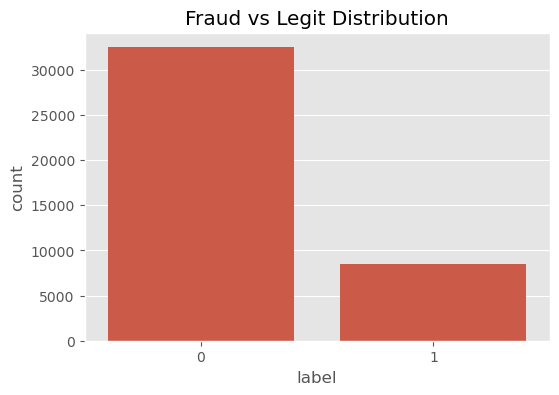

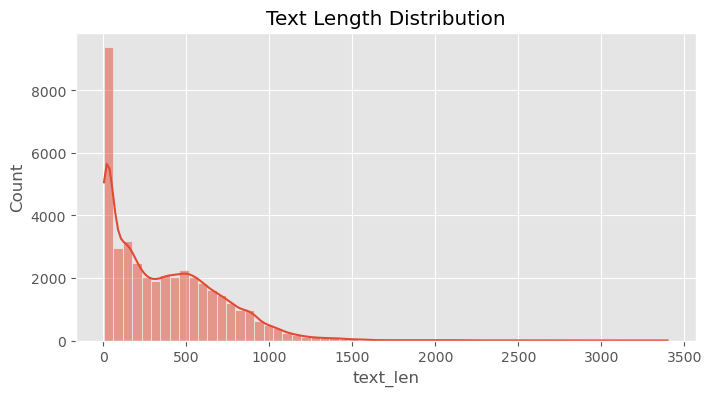

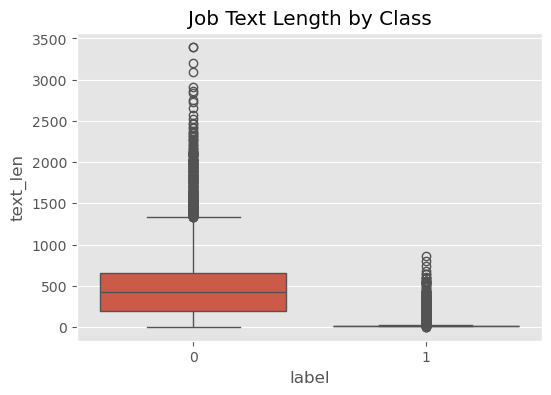

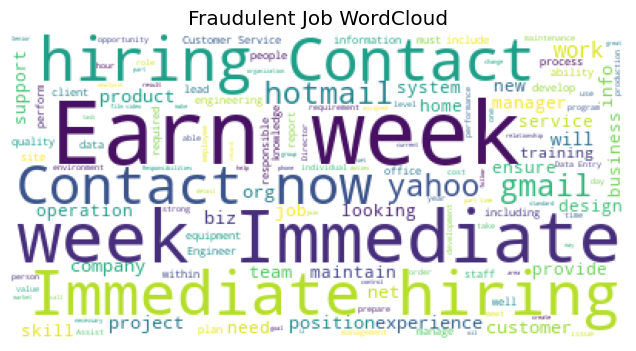

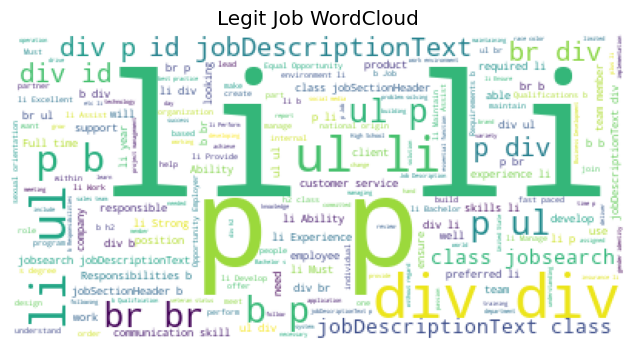

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

plt.style.use("ggplot")

df = pd.read_csv("data/processed/train.csv")

df["text"] = df["job_title"].fillna("") + " " + df["job_description"].fillna("")
df["text_len"] = df["text"].apply(lambda x: len(str(x).split()))

print("Dataset Shape:", df.shape)
df.head()

# Label counts
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="label")
plt.title("Fraud vs Legit Distribution")
plt.show()

# Length distribution
plt.figure(figsize=(8,4))
sns.histplot(df["text_len"], kde=True, bins=60)
plt.title("Text Length Distribution")
plt.show()

# Length by label
plt.figure(figsize=(6,4))
sns.boxplot(x=df["label"], y=df["text_len"])
plt.title("Job Text Length by Class")
plt.show()

# WordCloud
fraud_text = " ".join(df[df["label"] == 1]["text"])
legit_text = " ".join(df[df["label"] == 0]["text"])

plt.figure(figsize=(10,4))
plt.imshow(WordCloud(background_color="white").generate(fraud_text))
plt.axis("off")
plt.title("Fraudulent Job WordCloud")
plt.show()

plt.figure(figsize=(10,4))
plt.imshow(WordCloud(background_color="white").generate(legit_text))
plt.axis("off")
plt.title("Legit Job WordCloud")
plt.show()


# 🧪 **Cell — Test Classical ML Models (LR, RF, XGBoost) Using Embedding Features**

This cell loads your saved classical machine-learning models (Logistic Regression, Random Forest, and optionally XGBoost), encodes new job descriptions using the sentence-transformer embedding model, and produces **fraud probability predictions** for each model.

It provides a fast, lightweight alternative to the transformer-based detector.

---

## 📁 **1. Load Trained Models & Embedding Pipeline**

The cell loads the full classical ML stack:

### **ML classifiers:**

* Logistic Regression (`clf_lr`)
* Random Forest (`clf_rf`)
* XGBoost (`clf_xgb`, if available)

### **Feature extractors:**

* `embed` → SentenceTransformer embedding model
* `tfidf` → optional TF-IDF vectorizer (not used in final inference)

All models were saved earlier using `joblib`.

---

## 🔍 **2. `test_ml_model()` — Fraud Scoring Function**

This function accepts:

* `job_title`
* `job_description`

### **Step-by-step process**

1. Combine the text

2. Generate semantic embeddings using:

   ```python
   emb = embed.encode([text])[0]
   ```

3. Reshape into model input format

4. Run each ML classifier:

   ```python
   clf_lr.predict_proba(X)[0][1] → fraud probability
   clf_rf.predict_proba(X)[0][1]
   clf_xgb.predict_proba(X)[0][1]  (if available)
   ```

5. Print clean, formatted results

6. Return probabilities as a dictionary

### **Outputs**

Each model returns:

* value in **range 0 → 1**
* higher value = higher likelihood of fraud

---

## 🧪 **3. Example Test Cases**

Two example prompts demonstrate model behavior:

### 🚩 **Case 1 — Suspicious Job Posting**

Remote + unrealistic earnings → ML models should output **high fraud probability**.

### ✅ **Case 2 — Normal Software Engineer Role**

Technical description with real requirements → expect **low fraud probability**.

---

## 🎯 **Purpose of This Cell**

This cell enables:

* Quick testing of ML models
* Comparing fraud probabilities across LR, RF, XGB
* Debugging the embedding + ML pipeline
* Using classical models as a backup / ensemble predictor

These ML models complement your transformer model in the **full multimodal fraud detection system**.



In [47]:
import joblib
import numpy as np

# Load models
clf_lr = joblib.load("models/clf_lr.joblib")
clf_rf = joblib.load("models/clf_rf.joblib")
try:
    clf_xgb = joblib.load("models/clf_xgb.joblib")
except:
    clf_xgb = None

embed = joblib.load("models/embed_model.joblib")
tfidf = joblib.load("models/tfidf.joblib")


def test_ml_model(job_title, job_description):
    text = job_title + " " + job_description
    emb = embed.encode([text])[0]  # vector
    X = emb.reshape(1, -1)

    results = {
        "LR_probability": float(clf_lr.predict_proba(X)[0][1]),
        "RF_probability": float(clf_rf.predict_proba(X)[0][1]),
    }

    if clf_xgb:
        results["XGB_probability"] = float(clf_xgb.predict_proba(X)[0][1])

    print("\n=======================")
    print("ML Model Results")
    print("=======================\n")
    for k, v in results.items():
        print(f"{k}: {v:.4f}")
    return results


# ------------------------------
# Test Examples
# ------------------------------
test_ml_model(
    "Data Entry Operator",
    "Earn $5000/week working from home. Immediate hiring. Send your bank details."
)

test_ml_model(
    "Software Engineer",
    "We are hiring a backend Python developer with 3+ years of experience."
)



ML Model Results

LR_probability: 0.9936
RF_probability: 0.9444
XGB_probability: 1.0000

ML Model Results

LR_probability: 0.1323
RF_probability: 0.3139
XGB_probability: 0.0003


{'LR_probability': 0.132347990882963,
 'RF_probability': 0.31390871254265085,
 'XGB_probability': 0.00026839712518267334}

'Input:\n"Earn $7000 weekly. No experience needed. Immediate joiners required."\n\nOutput:\n\n{\n  "company_auth_score": 32.5,\n  "company_label": "High Risk",\n  "company_bucket": "High Risk",\n\n  "job_auth_score": 8.41,\n  "job_label": "High Fraud Probability",\n  "job_bucket": "High Fraud",\n  "job_fraud_probability": 0.9159,\n\n  "email_auth_score": 22.0,\n  "email_fraud_score": 78.0,\n  "email_fraud_probability": 0.7800,\n  "email_interpretation": "Likely Phishing",\n\n  "final_recommendation": "DO_NOT_APPLY",\n\n  "overall_multimodal_label": "DO_NOT_APPLY",\n  "overall_multimodal_probability": 0.8421\n}\n\n✅ Example 2 — Legitimate Job\n\nInput:\n"Looking for a React developer with 2+ years of experience."\n\nOutput:\n\n{\n  "company_auth_score": 94.0,\n  "company_label": "Strong",\n  "company_bucket": "Low Risk",\n\n  "job_auth_score": 87.44,\n  "job_label": "Authentic",\n  "job_bucket": "Strong Authentic Job",\n  "job_fraud_probability": 0.1256,\n\n  "email_auth_score": 91.0,\n



# 🤖 **Cell — Load Fine-Tuned Transformer Model + Run Fraud Predictions**

This cell loads your **fine-tuned BERT-Tiny transformer classifier** and defines a reusable function to score job postings for fraud probability.
It enables semantic, context-aware fraud detection beyond what classical ML models can capture.

---

## 📁 **1. Load Fine-Tuned Transformer Model**

```python
MODEL_DIR = "bert_tiny_finetuned_model"
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.eval()
```

What this does:

* Loads the **saved tokenizer** and **fine-tuned BERT-Tiny model**
* Sets the model to evaluation mode (`model.eval()`)
* Ensures the transformer is ready for inference

---

## 🔍 **2. `test_transformer()` — Fraud Probability Function**

This function accepts:

* `job_title`
* `job_description`

It merges them → tokenizes → feeds into the transformer → extracts prediction probabilities.

### Key components:

### 🧹 **Text Concatenation**

```python
text = job_title + " " + job_description
```

### 🧪 **Tokenization**

Handles padding, truncation, and converts input into PyTorch tensors:

```python
inputs = tokenizer(
    text,
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)
```

### 🤖 **Transformer Inference**

```python
outputs = model(**inputs)
probs = torch.softmax(outputs.logits, dim=1)[0].numpy()
```

Produces two probabilities:

* `probs[0]` → Legit probability
* `probs[1]` → Fraud probability

---

## 📊 **3. Print and Return a Human-Readable Result**

The function displays:

```
Legit Probability  
Fraud Probability  
Predicted Label  
```

If `fraud_prob > 0.5`, the model labels it **FRAUD**.

Finally, the function returns:

```python
return fraud_prob
```

This value is later used in the **full multimodal scoring pipeline**.

---

## 🧪 **4. Example Tests**

Two useful test cases are shown:

### 🚩 **Suspicious Job Example**

Remote + high weekly earnings → transformer should mark as **fraudulent**.

### ✅ **Legitimate Technical Job**

NLP research engineer → transformer should classify as **legit**.

These examples validate the transformer model’s behavior after fine-tuning.

---

## 🎯 **Purpose of This Cell**

This cell provides:

* A **standalone transformer inference module**
* A **probability-based fraud classifier**
* Human-readable debug outputs
* A function easily integrated into the Flask backend

It forms the core of the **DL component** of your hybrid fraud detection system.



In [48]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np

MODEL_DIR = "bert_tiny_finetuned_model"

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.eval()

def test_transformer(job_title, job_description):
    text = job_title + " " + job_description

    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)[0].numpy()

    fraud_prob = float(probs[1])
    legit_prob = float(probs[0])

    print("\n==============================")
    print("Transformer Model Prediction")
    print("==============================")
    print(f"Legit Probability:  {legit_prob:.4f}")
    print(f"Fraud Probability: {fraud_prob:.4f}")
    print(f"Label: {'FRAUD' if fraud_prob > 0.5 else 'LEGIT'}")
    print("==============================\n")

    return fraud_prob


# ------------------------------
# Test Examples
# ------------------------------
test_transformer(
    "Customer Support Representative",
    "Work remotely and earn up to $6000/week. No experience required, apply now!"
)

test_transformer(
    "Machine Learning Engineer",
    "We are looking for an ML engineer to join our research team working with NLP models."
)



Transformer Model Prediction
Legit Probability:  0.0001
Fraud Probability: 0.9999
Label: FRAUD


Transformer Model Prediction
Legit Probability:  0.9999
Fraud Probability: 0.0001
Label: LEGIT



0.00010170690802624449